In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import beta

from get_model_training_data_05 import get_features_and_data

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [2]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

training examples = 2256, testing examples = 251


## Model-Building and Evaluation

In [3]:
with pm.Model() as model:
    # data
    y = pm.MutableData("y", train_df["binary_target"])
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("y_pred", p=p, observed=y)

In [4]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


### In-Sample Evaluation

In [5]:
# with model:
#     pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=1024)

In [6]:
# az.plot_ppc(idata, num_pp_samples=100)

### Out-of-Sample Evaluation

In [7]:
with model:
    pm.set_data({"features" : test_df[feature_names].T, "y" : test_df["binary_target"]})
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y_pred]


In [8]:
y_pred = [Counter(y).most_common(1)[0][0] for y in
          idata.posterior_predictive["y_pred"].stack(all_draws=["chain", "draw"]).values]

In [9]:
(precision_score(test_df["binary_target"], y_pred), recall_score(test_df["binary_target"], y_pred))

(0.9333333333333333, 0.782608695652174)

In [10]:
foo = [Counter(y) for y in idata.posterior_predictive["y_pred"].stack(all_draws=["chain", "draw"]).values]
y_pred_proba = [y[1] / sum(y.values()) for y in foo]

In [11]:
mape(test_df["prob_of_release"], y_pred_proba)

0.3332254761064522

## Predictions for the Next Month

In [12]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("y_pred", p=p, observed=df["binary_target"], shape=features.shape[1])

In [13]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [14]:
with model:
    pm.set_data({"features" : next_month[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred", "p"])

Sampling: [y_pred]


In [15]:
next_month["predicted_binary"] = [Counter(y).most_common(1)[0][0] for y in
                                  pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values]

In [16]:
foo = [Counter(y) for y in pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values]
next_month["predicted_prob"] = [y[1] / sum(y.values()) for y in foo]

In [17]:
hdi = pm.hdi(pred_next.predictions["p"], hdi_prob=0.95)
next_month["predicted_min"] = hdi["p"][:, 0]
next_month["predicted_max"] = hdi["p"][:, 1]

In [18]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max", "predicted_binary"]]

,index,predicted_min,predicted_prob,predicted_max,predicted_binary
1,2023-12-31,0.030701,0.05750,0.099066,0
2,2024-01-01,0.191575,0.28300,0.387387,0
3,2024-01-02,0.390551,0.50725,0.627148,1
4,2024-01-03,0.574785,0.68050,0.785025,1
5,2024-01-04,0.759723,0.82700,0.900999,1
6,2024-01-05,0.887436,0.93175,0.959665,1
7,2024-01-06,0.938171,0.96150,0.980169,1
8,2024-01-07,0.977153,0.98700,0.993635,1
9,2024-01-08,0.992813,0.99575,0.998263,1
10,2024-01-09,0.997153,0.99800,0.999344,1


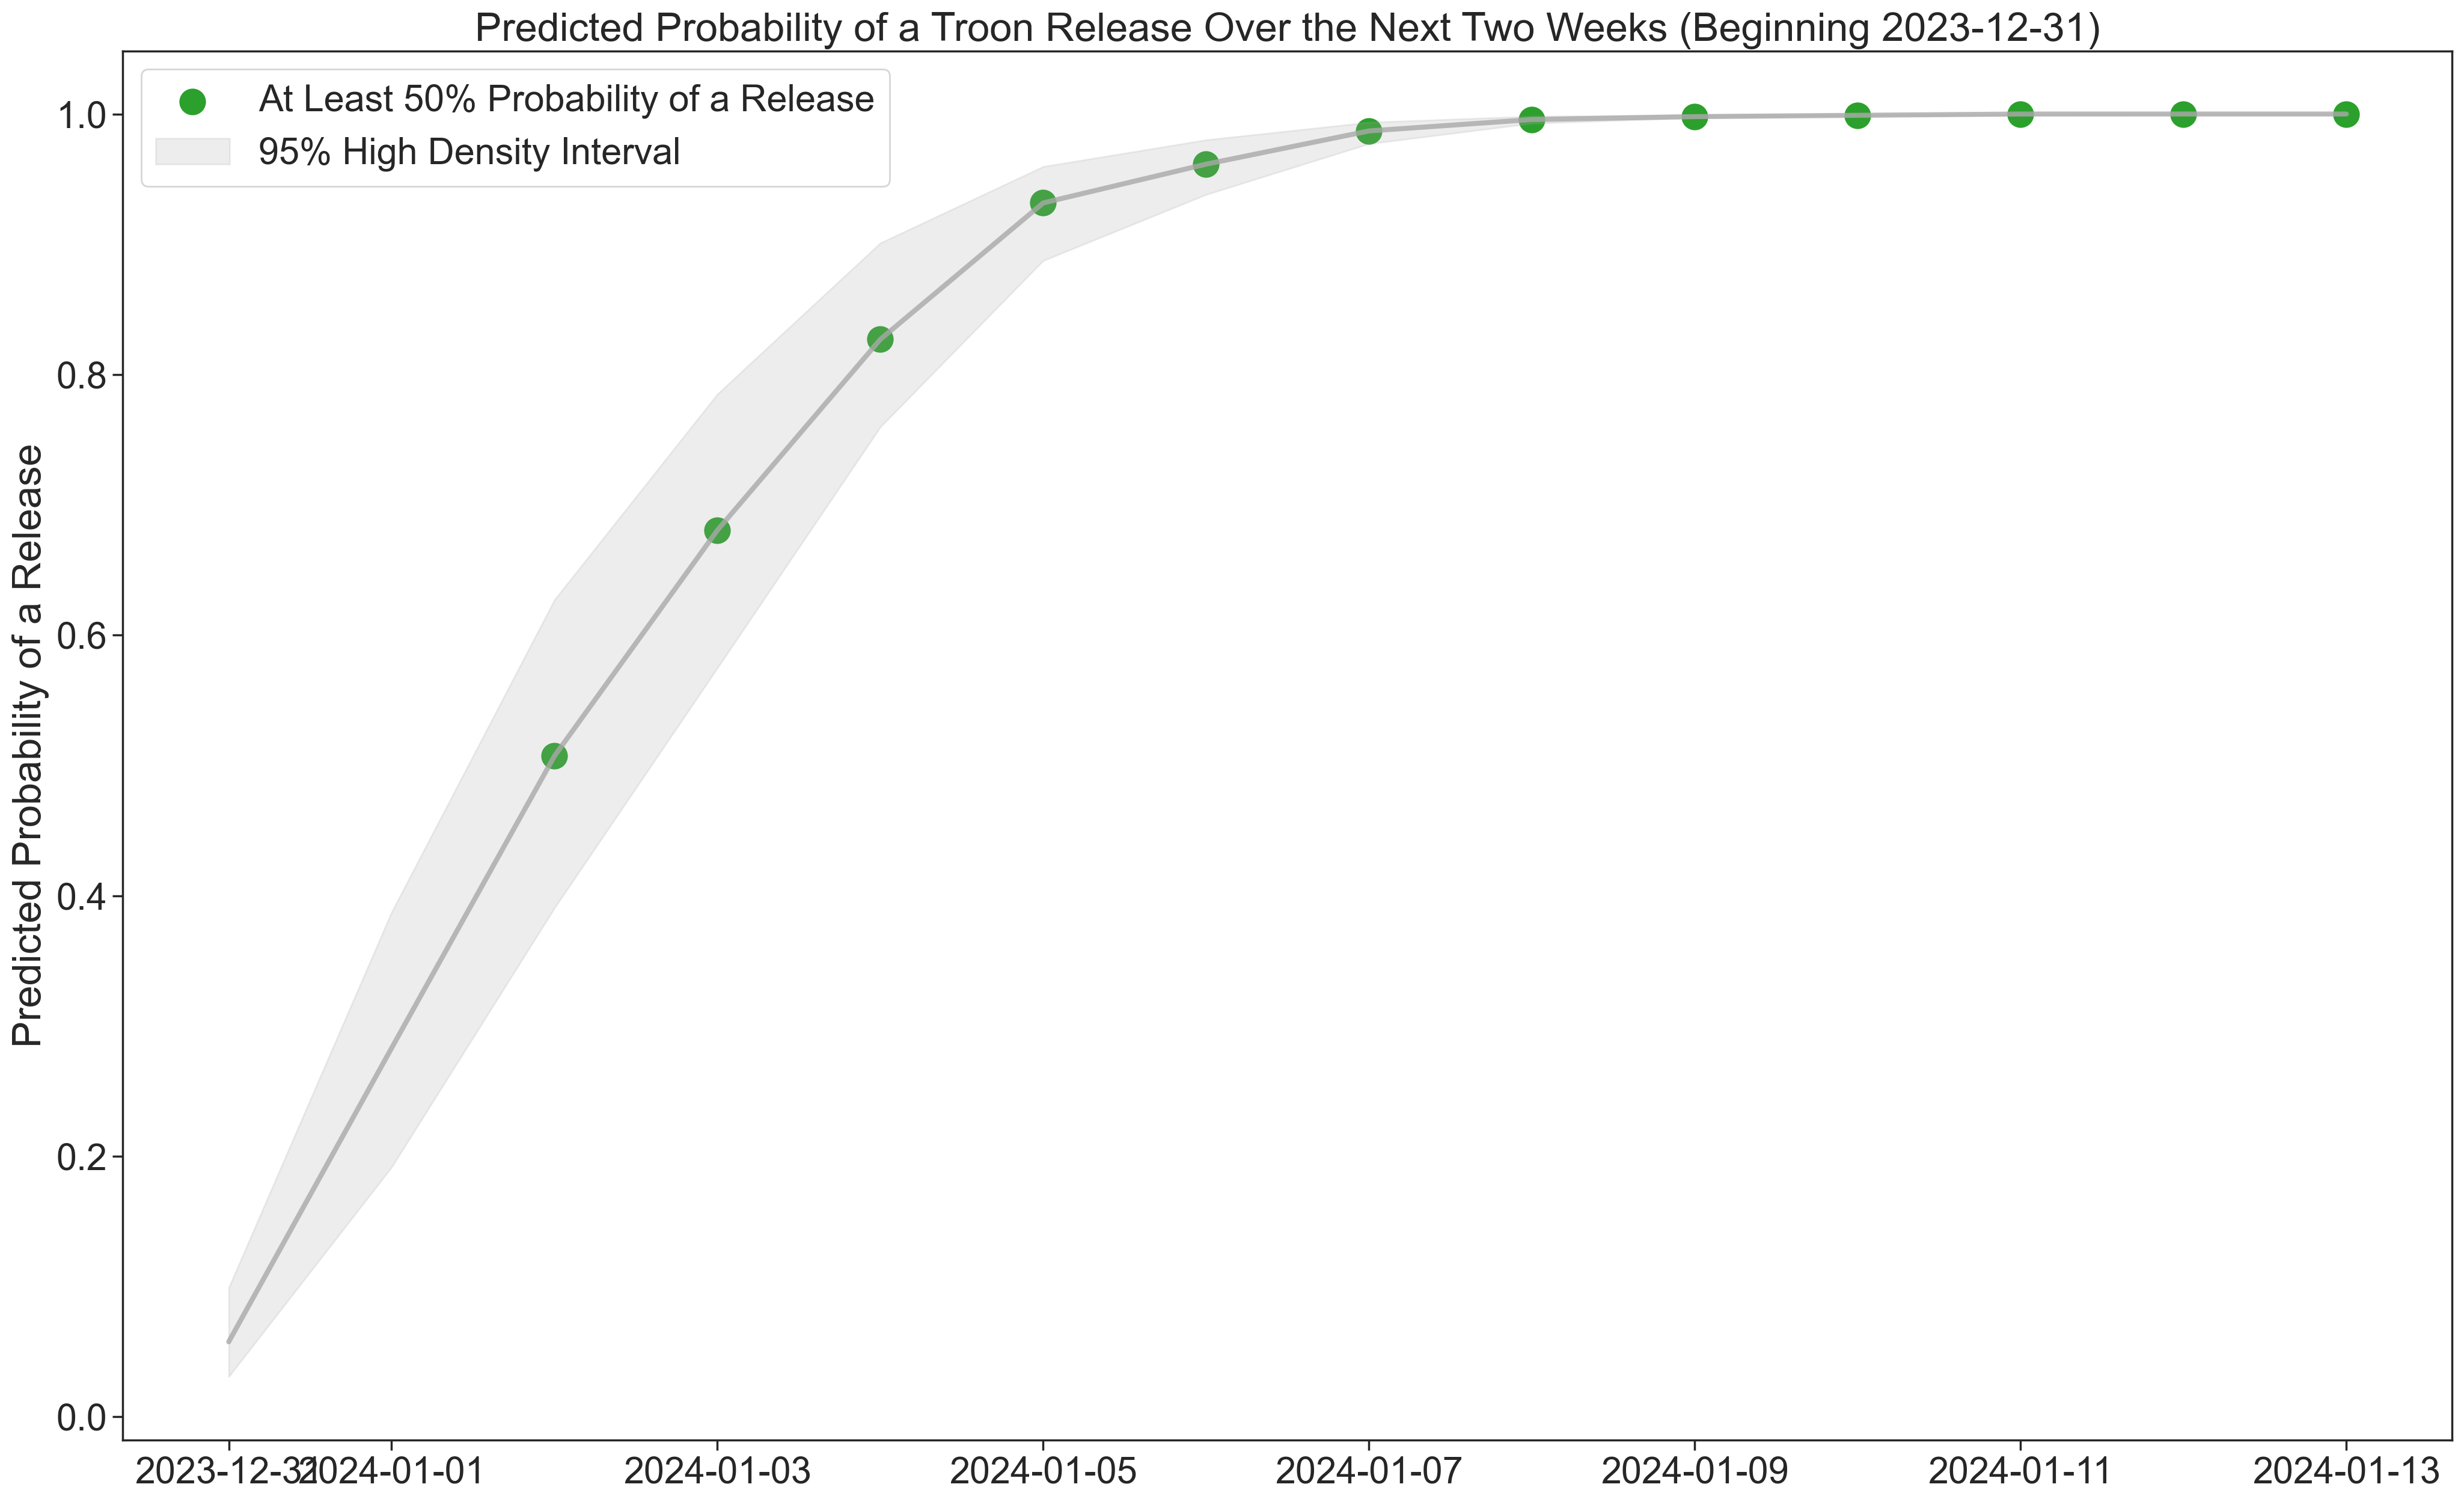

In [19]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()